In [1]:
import sys; sys.path.append('..')
import torch
from torchsummary import summary
from src.models.autoencoder import AutoEncoder

DEVICE = 'cuda:3'

In [2]:
from torchvision.datasets import CIFAR10
import torchvision.transforms as T

ds_train = CIFAR10('../data/cifar10', train=True, transform=T.Compose([
    T.ToTensor(),
    #T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
]))
ds_test = CIFAR10('../data/cifar10', train=False, transform=T.Compose([
    T.ToTensor(),
    #T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
]))

In [3]:
from torch.utils.data import DataLoader
from torch.utils.data import Subset

# ds_train = Subset(ds_train, range(100))
# ds_test = Subset(ds_test, range(100))

dl_train = DataLoader(ds_train, batch_size=256, shuffle=True)
dl_test = DataLoader(ds_test, batch_size=256, shuffle=False)

In [11]:
import torch
import torch.nn as nn
from torch import Tensor
from firelab.config import Config

from src.models.layers import ConvBNReLU, ConvTransposeBNReLU, Reshape


import torch
import torch.nn as nn
from torch import Tensor
from firelab.config import Config

from src.models.layers import ConvBNReLU, ConvTransposeBNReLU, Reshape


class AutoEncoder(nn.Module):
    def __init__(self, config: Config):
        super(AutoEncoder, self).__init__()

        self.encoder = Encoder(config)
        self.decoder = Decoder(config)

    def forward(self, x: Tensor) -> Tensor:
        return self.decoder(self.encoder(x))


class Encoder(nn.Module):
    def __init__(self, config: Config):
        super(Encoder, self).__init__()

#         self.model = nn.Sequential(
#             ConvBNReLU(3, 16, 3, False),
#             ConvBNReLU(16, 64, 3, False, stride=2),
#             ConvBNReLU(64, 256, 3, False, stride=2),
#             ConvBNReLU(256, 512, 3, False, stride=2),
#             #Reshape([-1, 2048])
#         )
#         self.model = nn.Sequential(
#             nn.Conv2d(3, 12, 4, stride=2, padding=1),            # [batch, 12, 16, 16]
#             nn.ReLU(),
#             nn.Conv2d(12, 24, 4, stride=2, padding=1),           # [batch, 24, 8, 8]
#             nn.ReLU(),
#             nn.Conv2d(24, 48, 4, stride=2, padding=1),           # [batch, 48, 4, 4]
#             nn.ReLU(),
#         )
        self.model = nn.Sequential(
            nn.Conv2d(3, 16, 4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 64, 4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 256, 4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 512, 3, stride=2, padding=1),
            nn.ReLU(),
        )

    def forward(self, x: Tensor) -> Tensor:
        return self.model(x)
    

class Decoder(nn.Module):
    def __init__(self, config: Config):
        super(Decoder, self).__init__()

#         self.model = nn.Sequential(
#             #Reshape([-1, 512, 2, 2]),
#             ConvTransposeBNReLU(512, 256, 4, stride=2, padding=1),
#             ConvTransposeBNReLU(256, 256, 4, stride=2, padding=1),
#             ConvTransposeBNReLU(256, 64, 4, stride=2, padding=1),
#             ConvTransposeBNReLU(64, 3, 4, stride=2, padding=1),
#             nn.Sigmoid(),
#         )
        self.model = nn.Sequential(
            nn.ConvTranspose2d(512, 256, 4, stride=2, padding=1),  # [batch, 24, 8, 8]
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, 4, stride=2, padding=1),  # [batch, 24, 8, 8]
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1),  # [batch, 12, 16, 16]
            nn.ReLU(),
            nn.ConvTranspose2d(64, 3, 4, stride=2, padding=1),   # [batch, 3, 32, 32]
            nn.Sigmoid(),
        )

    def forward(self, x: Tensor) -> Tensor:
        return self.model(x)


class ShapePrinter(nn.Module):
    def __init__(self, title: str='unknown'):
        super(ShapePrinter, self).__init__()
        self.title = title

    def forward(self, x):
        print(self.title, x.shape, x.flatten(1).shape)
        return x

In [12]:
# ae = AutoEncoder(None).to('cuda')
# summary(ae, (3, 32, 32))

In [13]:
from tqdm import tqdm
import torch.nn.functional as F
import numpy as np

ae = AutoEncoder(None).to(DEVICE)
optim = torch.optim.Adam(ae.parameters())
max_num_epochs = 100


def validate_ae(model, dataloader):
    all_losses = []
    model.eval()
    
    with torch.no_grad():
        #for x, _ in tqdm(dataloader, desc='Validating', total=len(dataloader)):
        for x, _ in dataloader:
            x = x.to(DEVICE)
            #losses = F.binary_cross_entropy(model(x), x, reduction='none')
            losses = F.mse_loss(model(x), x, reduction='none')
            all_losses.extend(losses.cpu().tolist())
            
    return np.mean(all_losses)


for epoch in range(1, max_num_epochs + 1):
    for i, (x, _) in tqdm(enumerate(dl_train), desc='Training', total=len(dl_train)):
    #for i, (x, _) in enumerate(dl_train):
        ae.train()
        x = x.to(DEVICE)
        
        #loss = F.binary_cross_entropy(ae(x), x)
        loss = F.mse_loss(ae(x), x)
        optim.zero_grad()
        loss.backward()
        optim.step()
    
    if epoch % 10 == 0:
        print(f'[train] Epoch {epoch}. {validate_ae(ae, dl_train)}')
        print(f'[val] Epoch {epoch}: {validate_ae(ae, dl_test)}')

Training: 100%|██████████| 196/196 [00:08<00:00, 22.82it/s]


[train] Epoch 10. 0.004840629668714331


Training:   1%|          | 2/196 [00:00<00:09, 19.90it/s]

[val] Epoch 10: 0.004866561924633486


Training: 100%|██████████| 196/196 [00:08<00:00, 22.99it/s]


[train] Epoch 20. 0.003053527125347675


Training:   2%|▏         | 3/196 [00:00<00:09, 20.92it/s]

[val] Epoch 20: 0.0030875497366148227


Training: 100%|██████████| 196/196 [00:08<00:00, 22.80it/s]


[train] Epoch 30. 0.0030201760098860766


Training:   2%|▏         | 3/196 [00:00<00:09, 20.99it/s]

[val] Epoch 30: 0.0030637408907218102


Training: 100%|██████████| 196/196 [00:08<00:00, 23.45it/s]


[train] Epoch 40. 0.0019588685000193383


Training:   2%|▏         | 3/196 [00:00<00:09, 21.13it/s]

[val] Epoch 40: 0.002003090748195999


Training: 100%|██████████| 196/196 [00:08<00:00, 22.98it/s]


[train] Epoch 50. 0.0016936797113985597


Training:   1%|          | 2/196 [00:00<00:15, 12.76it/s]

[val] Epoch 50: 0.0017366285320124326


Training: 100%|██████████| 196/196 [00:08<00:00, 23.49it/s]


[train] Epoch 60. 0.001566663680701479


Training:   2%|▏         | 3/196 [00:00<00:09, 21.18it/s]

[val] Epoch 60: 0.0016108026419183138


Training: 100%|██████████| 196/196 [00:08<00:00, 23.29it/s]


[train] Epoch 70. 0.001395300340485556


Training:   1%|          | 2/196 [00:00<00:13, 13.91it/s]

[val] Epoch 70: 0.001436901520452206


Training: 100%|██████████| 196/196 [00:08<00:00, 23.16it/s]


[train] Epoch 80. 0.0012399065580644842


Training:   2%|▏         | 3/196 [00:00<00:09, 20.75it/s]

[val] Epoch 80: 0.00128195647306603


Training: 100%|██████████| 196/196 [00:08<00:00, 23.17it/s]


[train] Epoch 90. 0.00111746975289753


Training:   2%|▏         | 3/196 [00:00<00:09, 21.12it/s]

[val] Epoch 90: 0.0011552116707733275


Training: 100%|██████████| 196/196 [00:08<00:00, 22.92it/s]


[train] Epoch 100. 0.0012036252806219808
[val] Epoch 100: 0.0012379098337337157


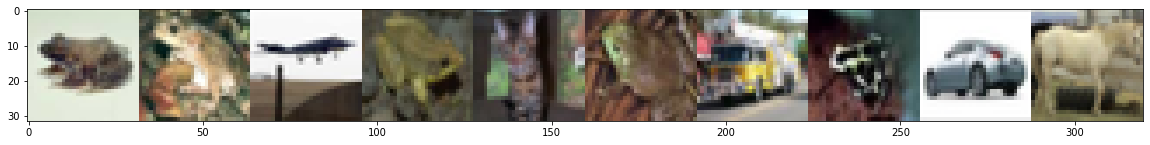

In [32]:
import random
import matplotlib.pyplot as plt

ae.eval()

with torch.no_grad():
    imgs = [ds_test[i][0] for i in random.sample(range(len(ds_test)), 10)]
    recs = [ae(img.unsqueeze(0).to(DEVICE)).cpu().squeeze(0) for img in imgs]

    imgs = [img.permute(1, 2, 0).numpy() for img in imgs]
    recs = [rec.permute(1, 2, 0).numpy() for rec in recs]


plt.figure(figsize=(20, 5))
plt.imshow(np.stack(imgs, axis=1).reshape(32, -1, 3), interpolation='nearest')

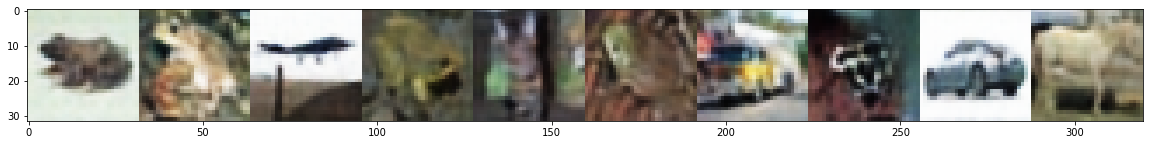

In [33]:
plt.figure(figsize=(20, 5))
plt.imshow(np.stack(recs, axis=1).reshape(32, -1, 3), interpolation='nearest')

In [66]:
def extract_features(ae, dataloader):
    ae.eval()
    
    y = []
    feats = []
    
    with torch.no_grad():
        for batch in dataloader:
            feats.extend(ae.encoder(batch[0].to(DEVICE)).cpu().flatten(1).tolist())
            y.extend(batch[1])
            
    return feats, y

feats_train, y_train = extract_features(ae, dl_train)
feats_test, y_test = extract_features(ae, dl_test)

In [81]:
feats_dl_train = DataLoader(list(zip(*[feats_train, y_train])), batch_size=256, shuffle=True, collate_fn=lambda b: list(zip(*b)))
feats_dl_test = DataLoader(list(zip(*[feats_test, y_test])), batch_size=256, shuffle=False, collate_fn=lambda b: list(zip(*b)))

In [74]:
ds = list(zip(*[feats_train, y_train]))

In [92]:
classifier = nn.Sequential(
    nn.Linear(2048, 512),
    nn.BatchNorm1d(512),
    nn.ReLU(),
    nn.Linear(512, 100),
    nn.BatchNorm1d(100),
    nn.ReLU(),
    nn.Linear(100, 10)
).to(DEVICE)

max_num_epochs = 100
optim = torch.optim.Adam(classifier.parameters(), lr=1e-2)

for epoch in range(max_num_epochs):
    for batch in feats_dl_train:
        x = torch.tensor(batch[0]).to(DEVICE)
        y = torch.tensor(batch[1]).to(DEVICE)
        
        logits = classifier(x)
        loss = F.cross_entropy(logits, y)
        acc = (logits.argmax(dim=1) == y).float().mean().detach().cpu()
        
        optim.zero_grad()
        loss.backward()
        optim.step()
        
    print('acc', acc.item())

acc 0.5250000357627869
acc 0.637499988079071
acc 0.5625
acc 0.637499988079071
acc 0.6625000238418579
acc 0.7125000357627869
acc 0.612500011920929
acc 0.800000011920929
acc 0.6875
acc 0.862500011920929
acc 0.800000011920929
acc 0.887499988079071
acc 0.9000000357627869
acc 0.9625000357627869


KeyboardInterrupt: 

In [93]:
def validate_clf(clf_model, dataloader):
    losses = []
    accs = []

    with torch.no_grad():
        for x, y in dataloader:
            x = torch.tensor(x).to(DEVICE)
            y = torch.tensor(y).to(DEVICE)

            logits = clf_model(x)
            loss = F.cross_entropy(logits, y, reduction='none').cpu().tolist()
            acc = (logits.argmax(dim=1) == y).float().cpu().tolist()
            
            losses.extend(loss)
            accs.extend(acc)
        
    return np.mean(losses), np.mean(accs)

In [94]:
validate_clf(classifier, feats_dl_test)

(2.4282884196713566, 0.563)